In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [2]:
csv_path_jobs = "wandb_runs_time-to-train.csv"
df_jobs = pd.read_csv(csv_path_jobs)
print(df_jobs.shape)
df_jobs.sample(2)

(83, 13)


,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu
75,time-to-train_1b-llama-tok-us-central2-b-v4-25...,38.097598,38.896667,25.329472,2024-07-25 20:53:32 PDT,2024-07-27 11:47:20 PDT,meta-llama/Llama-2-7b-hf,1024,479.320786,42683,1204881408,128,46.723995
3,time-to-train_1b-llama-tok-us-west4-a-v5litepo...,9.822673,11.713611,8.262453,2024-07-31 01:01:07 PDT,2024-07-31 12:43:56 PDT,meta-llama/Llama-2-7b-hf,1024,757.340850,21999,1204881408,256,NaN


In [5]:
def get_tpu_type(run_name: str) -> str:
    # default value
    tpu_type = "v4-256"
    tpu_zone = "us"

    if "v4-256" in run_name or "v4" in run_name:
        tpu_type = "v4-256"
    else:
        tpu_type = "v5lite-256"

    if "europe-west4-b" in run_name:
        tpu_zone = "eu"
    else:
        tpu_zone = "us"
    return f"{tpu_type}({tpu_zone})"

df_jobs["tpu_type"] = df_jobs["run_name"].apply(get_tpu_type)
df_jobs["tpu_type"].value_counts()

tpu_type
v4-256(us)        48
v5lite-256(us)    35
Name: count, dtype: int64

In [6]:
df_jobs.columns

Index(['run_name', 'runtime', 'total_job_time', 'training_time', 'create_time',
       'heartbeat_time', 'tokenizer', 'train_batch_size',
       'examples_per_second', 'global_step', 'parameters', 'num_devices',
       'mfu', 'tpu_type'],
      dtype='object')

In [7]:
df_jobs["create_time"].head()

0    2024-07-31 04:52:09 PDT
1    2024-07-31 01:20:06 PDT
2    2024-07-31 01:01:52 PDT
3    2024-07-31 01:01:07 PDT
4    2024-07-30 23:00:39 PDT
Name: create_time, dtype: object

In [8]:
df_jobs["heartbeat_time"].head()

0    2024-07-31 10:18:30 PDT
1    2024-07-31 01:59:58 PDT
2    2024-07-31 12:43:51 PDT
3    2024-07-31 12:43:56 PDT
4    2024-07-31 12:43:53 PDT
Name: heartbeat_time, dtype: object

In [9]:
df_jobs["runtime"].head()

0    3.169891
1    0.662691
2    1.933807
3    9.822673
4    0.868638
Name: runtime, dtype: float64

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

/tmp/ipykernel_3054350/158867751.py:7: FutureWarning: Parsed string "2024-07-31 04:52:09 PDT" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['create_time'] = pd.to_datetime(df['create_time'])
/tmp/ipykernel_3054350/158867751.py:8: FutureWarning: Parsed string "2024-07-31 10:18:30 PDT" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['heartbeat_time'] = pd.to_datetime(df['heartbeat_time'])
/tmp/ipykernel_3054350/158867751.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = row['create_time'].floor('H')
/tmp/ipykernel_3054350/158867751.py:13: FutureWarning:

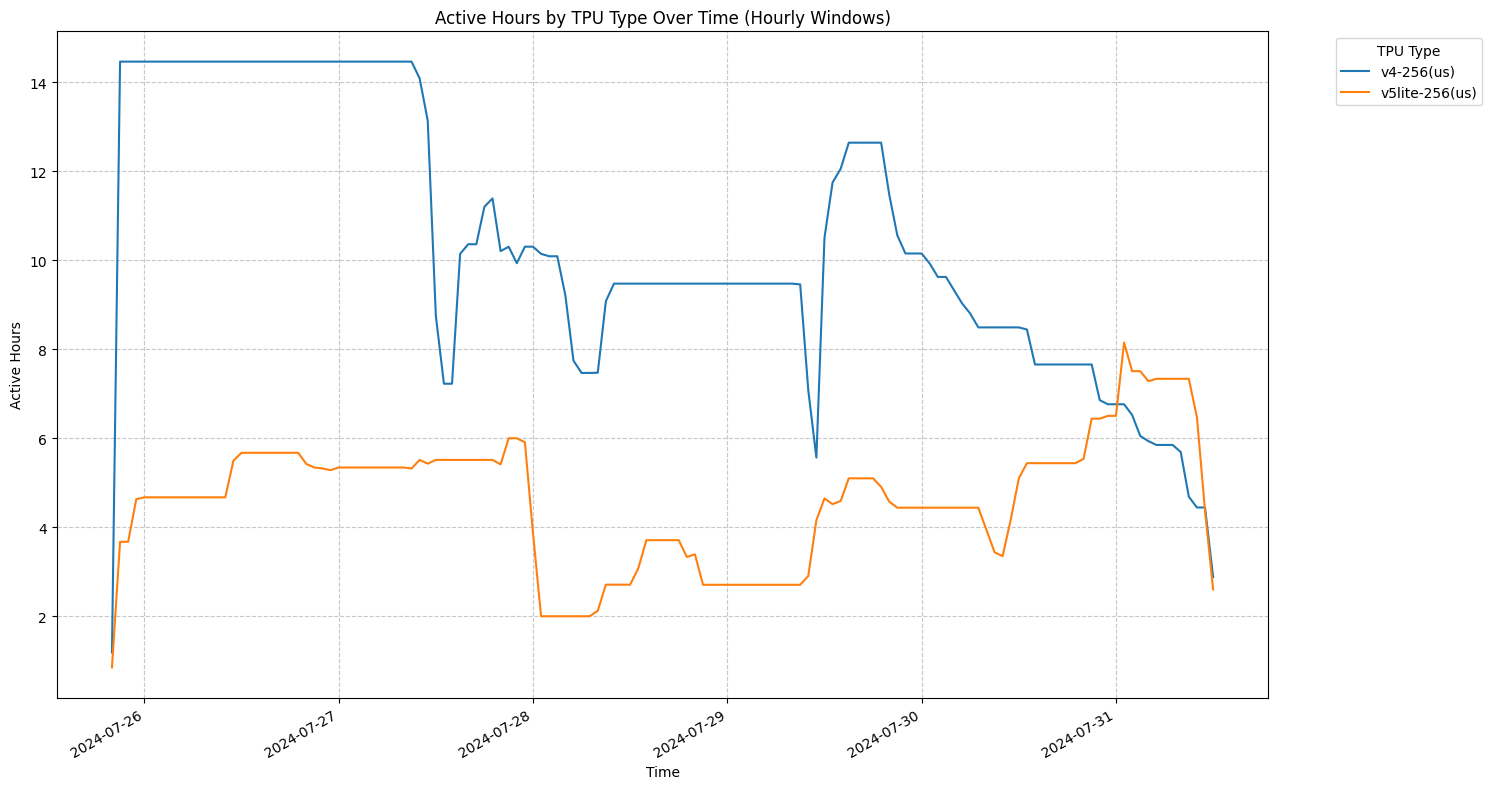

Total active hours by TPU type:
tpu_type
v4-256(us)        1422.084679
v5lite-256(us)     632.128283
dtype: float64

Peak active hours by TPU type:
tpu_type
v4-256(us)        14.460304
v5lite-256(us)     8.147740
dtype: float64

Average active hours by TPU type:
tpu_type
v4-256(us)        10.380180
v5lite-256(us)     4.614075
dtype: float64


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_tpu_hours(df):
    # Convert time columns to datetime if they aren't already
    df['create_time'] = pd.to_datetime(df['create_time'])
    df['heartbeat_time'] = pd.to_datetime(df['heartbeat_time'])

    # Function to generate hourly intervals and distribute runtime
    def distribute_runtime(row):
        start = row['create_time'].floor('H')
        end = row['heartbeat_time'].ceil('H')
        hours = pd.date_range(start=start, end=end, freq='H')
        total_period = (row['heartbeat_time'] - row['create_time']).total_seconds() / 3600
        runtime_per_hour = row['runtime'] / total_period if total_period > 0 else 0

        distributed_hours = []
        for hour_start in hours[:-1]:
            hour_end = hour_start + pd.Timedelta(hours=1)
            overlap_start = max(hour_start, row['create_time'])
            overlap_end = min(hour_end, row['heartbeat_time'])
            overlap_fraction = (overlap_end - overlap_start).total_seconds() / 3600
            distributed_hours.append({
                'hour': hour_start,
                'tpu_type': row['tpu_type'],
                'active_hours': runtime_per_hour * overlap_fraction
            })
        return pd.DataFrame(distributed_hours)

    # Apply the function to each row and concatenate the results
    hourly_data = pd.concat(df.apply(distribute_runtime, axis=1).tolist(), ignore_index=True)

    # Group by hour and tpu_type, and sum the active_hours
    active_hours = hourly_data.groupby(['hour', 'tpu_type'])['active_hours'].sum().unstack(fill_value=0)

    # Plotting
    plt.figure(figsize=(15, 8))
    for tpu in active_hours.columns:
        plt.plot(active_hours.index, active_hours[tpu], label=tpu)

    plt.xlabel('Time')
    plt.ylabel('Active Hours')
    plt.title('Active Hours by TPU Type Over Time (Hourly Windows)')
    plt.legend(title='TPU Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis
    plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("Total active hours by TPU type:")
    print(active_hours.sum())

    print("\nPeak active hours by TPU type:")
    print(active_hours.max())

    print("\nAverage active hours by TPU type:")
    print(active_hours.mean())

# Call the function with your dataframe
get_tpu_hours(df_jobs)
